## Thresholding

* Simple technique for image segmentation
* Okay for images with very distinct objects

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

## Dataset

['bimodal.jpg',
 'bimodal_hsv_noise.jpg',
 'carvana.jpg',
 'circle.jpg',
 'gradient.jpg',
 'headshot.jpg',
 'moon_gray_bg.jpg',
 'teapot_brown_bg.jpg',
 'teapot_white_bg.jpg',
 'white_oranges.jpg']

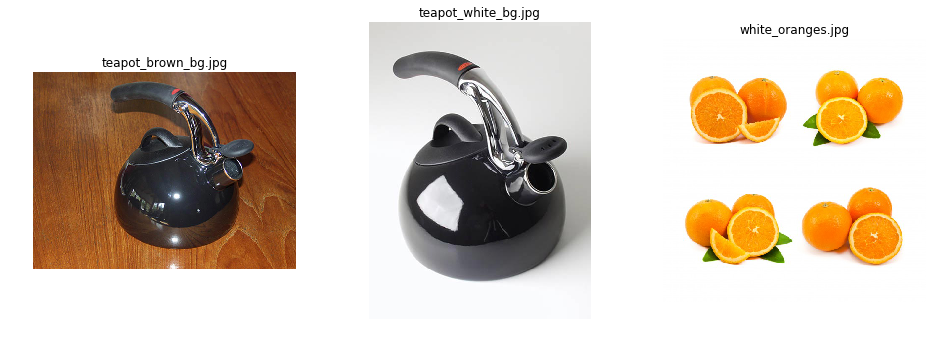

In [2]:
IMG_DIR = '../data/segmentation/'
fpaths, fnames = utils.files.get_paths_to_files(IMG_DIR, file_ext=c.JPG)
img_arrs = {
    fnames[i]: utils.imgs.load_img_as_arr(fpaths[i]) for i in range(len(fpaths))
}
utils.imgs.plot_samples_from_dir(IMG_DIR, shuffle=True, n=3)
fnames

## Helpers

In [3]:
def load_img(fname):
    img = img_arrs[fname]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray
    
def load_grayscale_img(fname):
    img = img_arrs[fname]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def format_1D_binary_mask(mask):
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, 0)
    mask = np.stack([mask,mask,mask], axis=1).squeeze().transpose(1,2,0)
    return mask.astype('float32')

def plot_binary_mask(arr, mask, title=None, color=(255,255,255)):
    arr = arr.copy()
    mask = format_1D_binary_mask(mask.copy())
    for i in range(3):
        arr[:,:,i][mask[:,:,i] > 0] = color[i]
    utils.imgs.plot_img_arr(arr, title=title)

def plot_binary_mask_overlay(img_arr, mask, fs=(18,18), title=None):
    mask = format_1D_binary_mask(mask.copy())
    fig = plt.figure(figsize=fs)
    a = fig.add_subplot(1,2,1)
    a.set_title(title)
    plt.imshow(img_arr.astype('uint8'))
    plt.imshow(mask, cmap='jet', alpha=.5) # interpolation='none'
    plt.show()
    
def cut_image(arr, mask, inverse=False, color=(255,255,255)):
    ## cv2.THRESH_TRUNC can be used
    arr = arr.copy()
    mask = format_1D_binary_mask(mask.copy())
    for i in range(3):
        if inverse:
            arr[:,:,i][mask[:,:,i] == 0] = color[i]
        else:
            arr[:,:,i][mask[:,:,i] > 0] = color[i]
    return arr

## Global Threshold

* If pixels > threshold, set to white, otherwise black
* https://docs.opencv.org/3.3.1/d7/d4d/tutorial_py_thresholding.html
* https://docs.opencv.org/3.0-beta/modules/imgproc/doc/miscellaneous_transformations.html?highlight=threshold#cv2.threshold

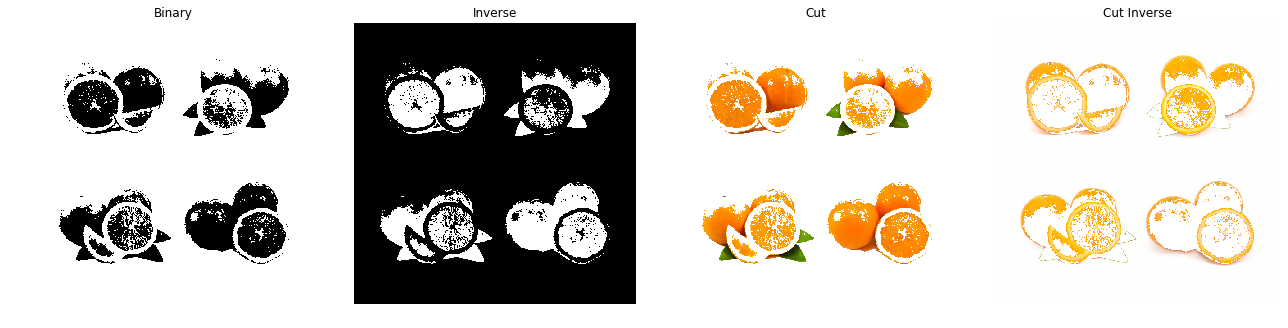

In [4]:
img,gray = load_img('white_oranges.jpg')

# If pixel > 127, set to 255, else 0
ret, mask = cv2.threshold(gray, thresh=127, maxval=255,
                            type=cv2.THRESH_BINARY)

# If pixel > 127, set to 0, else 255
ret, mask_inv = cv2.threshold(gray, thresh=127, maxval=255,
                                type=cv2.THRESH_BINARY_INV)

# If pixel > 127, set to 255, else pixel
ret, mask_passthrough = cv2.threshold(gray, thresh=127, maxval=255,
                                      type=cv2.THRESH_TOZERO)

cut_img = cut_image(img, mask)
cut_img_inv = cut_image(img, mask_inv)
utils.imgs.plot_imgs(imgs=[mask, mask_inv, cut_img, cut_img_inv], 
                     titles=['Binary', 'Inverse', 'Cut', 'Cut Inverse'], 
                     dim=(1,4), fs=(18,18))

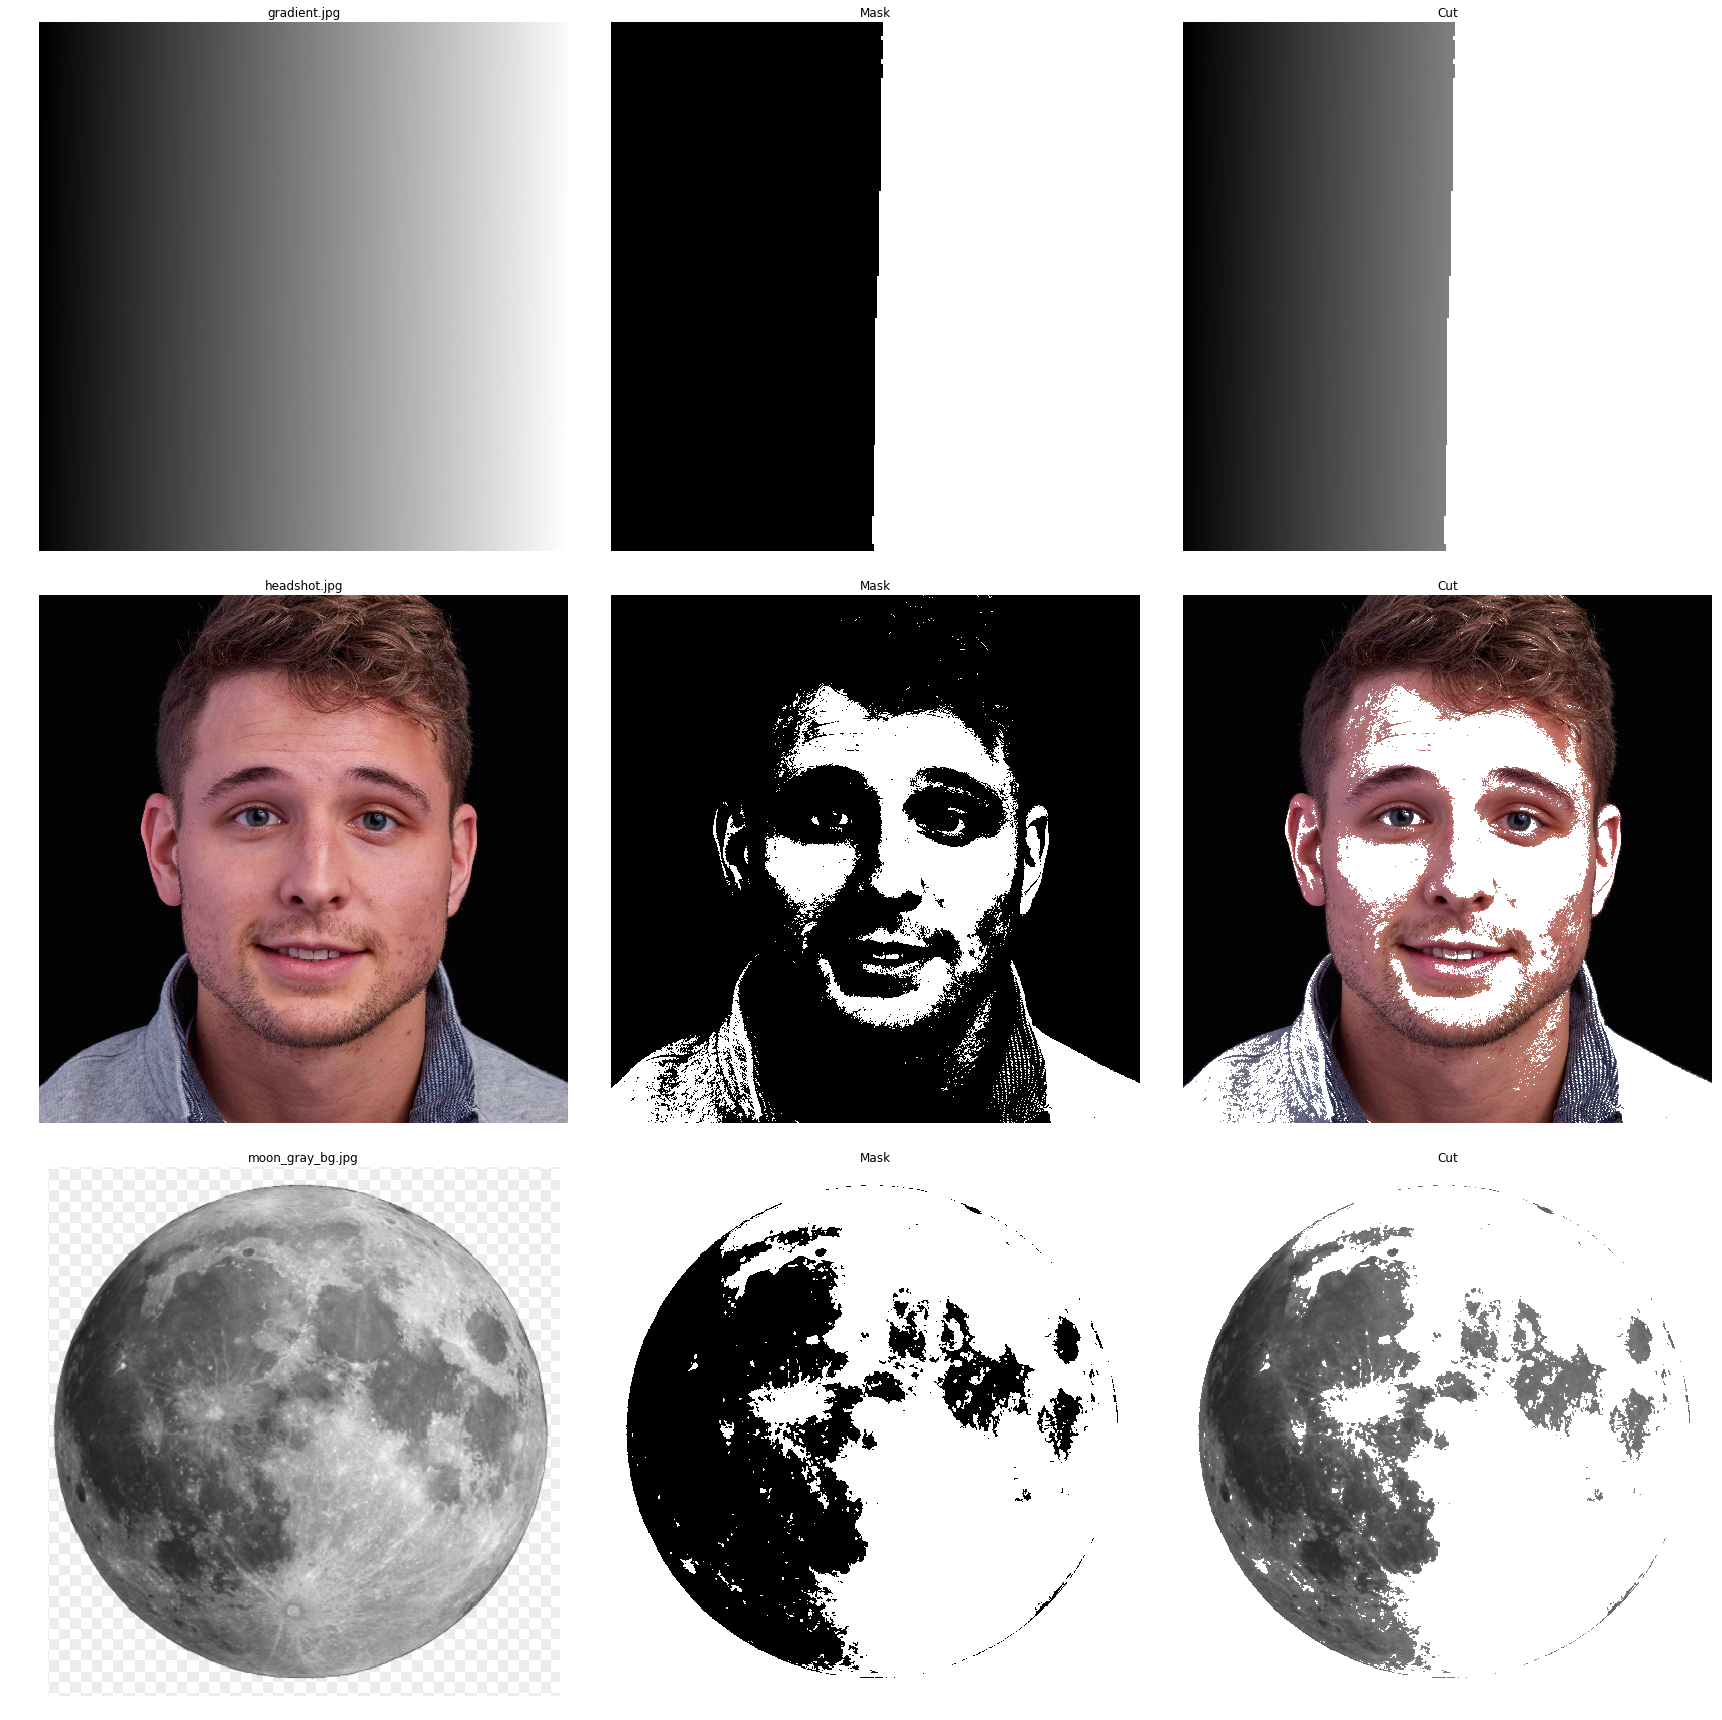

In [5]:
images = []
titles = []
for name,img in img_arrs.items():
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_img, thresh=127, maxval=255,
                                  type=cv2.THRESH_BINARY)
    masked_img = cut_image(img, thresh)
    images.extend([img, thresh, masked_img])
    titles.extend([name, 'Mask', 'Cut'])

utils.imgs.plot_imgs(images[12:], titles[12:], dim=(3,3), fs=(24,24))

## Adaptive Threshold

* Global thresholding gives bad results in different lighting conditions
* Adaptive thresholding calculates different thresholds for different regions of the image

Two Types

* Mean
    * threshold value equals mean of neighboring pixels
* Gaussian
    * threshold value equals weighted sum of neighboring pixels where weights are gaussian window
    
Gaussian Window
* ?

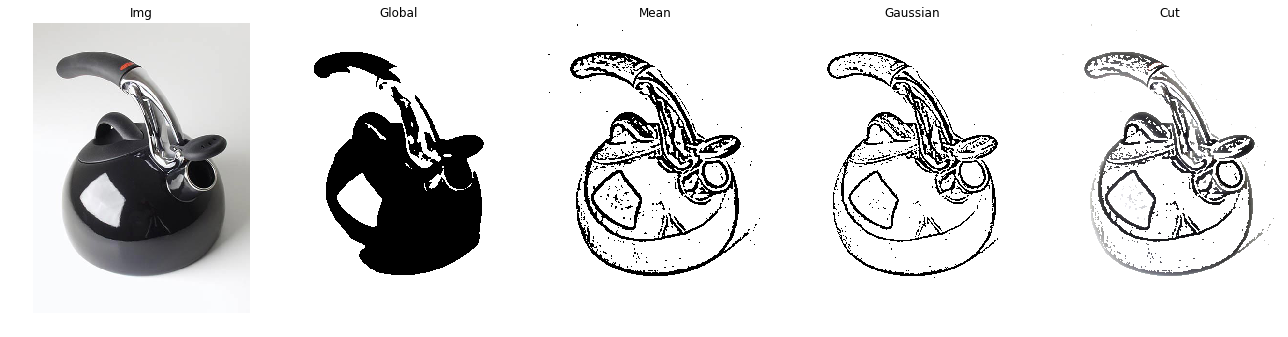

In [6]:
img,gray = load_img('teapot_white_bg.jpg')

# Add small blur to reduce jagged edges
gray = cv2.medianBlur(gray, 5)

# Global
_, global_mask = cv2.threshold(gray, thresh=127, maxval=255,
                               type=cv2.THRESH_BINARY)

# Adaptive Mean
mean_mask = cv2.adaptiveThreshold(
    gray, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY, blockSize=11, C=2)

# Adaptive Gaussian
gaussian_mask = cv2.adaptiveThreshold(
    gray, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY, blockSize=11, C=2)

cut_img = cut_image(img, mean_mask, inverse=False)
utils.imgs.plot_imgs(imgs=[img, global_mask, mean_mask, gaussian_mask, cut_img], 
                     titles=['Img', 'Global', 'Mean', 'Gaussian', 'Cut'], 
                     dim=(1,5), fs=(18,18))

## Otsu's Binarization

* Targets Bimodal Images - Images whose histograms have two peaks
* Selects a threshold value in the middle of the two peaks
* https://docs.opencv.org/3.3.1/d7/d4d/tutorial_py_thresholding.html

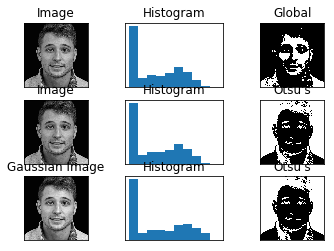

In [7]:
img,gray = load_img('headshot.jpg')

# Global
_, global_mask = cv2.threshold(gray, thresh=127, maxval=255,
                               type=cv2.THRESH_BINARY)

# Otsu
_, otsu_mask = cv2.threshold(gray, thresh=0, maxval=255,
                             type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Otsu w blur
blur = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)
_, otsu_blur = cv2.threshold(blur, thresh=0, maxval=255,
                             type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [gray, 0, global_mask,
          gray, 0, otsu_mask,
          blur, 0, otsu_blur]
titles = ['Image','Histogram','Global',
          'Image','Histogram',"Otsu's",
          'Gaussian Image','Histogram',"Otsu's"]

for i in range(3):    
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),10)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Sources

* https://en.wikipedia.org/wiki/Image_segmentation
* https://en.wikipedia.org/wiki/Thresholding_(image_processing)
* https://www.pyimagesearch.com/2014/09/08/thresholding-simple-image-segmentation-using-opencv/
* https://docs.opencv.org/3.3.1/d7/d4d/tutorial_py_thresholding.html